In [72]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rs
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from shapely.geometry import Point
from datetime import datetime
from sklearn.utils import resample
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn import metrics
import json

sys.path.append('../../src/')
from evaluation import create_stratified_sample as val
from evaluation import error_adjustments as err
from evaluation import consensus_labeling as con
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare Stratified Sample

Details  
- type: pixel-based analysis
- design: stratified sampling approach by class
- total study area (all pixels in the strata): 26 districts
- total samples: when choosing sample count, consider how many points will be dropped from buffer zone and lack of ARD (when creating validation data).

Code: `src/evaluation/create_stratified_sample.py`  
visual inspo: https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb

In [6]:
final = '../../tmp/ghana/preds/mosaic/final_2024-10-29.tif'
outfile = f'../../data/validation/stratified_sample/sampled_points.shp'
buffer = 1000
params_path = '../../params.yaml'

In [3]:
sampled_points = val.run_validation_workflow(final, 
                                             outfile,
                                             buffer,
                                             params_path)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 1067.0
Sampling 563 points for class 0 out of 264952720 available pixels.
Sampling 2 points for class 1 out of 1139546 available pixels.
Sampling 318 points for class 2 out of 148586138 available pixels.
Sampling 182 points for class 3 out of 85917262 available pixels.


## Gather additional validation points
To account for the samples labeled unknown, more validation points are required. This section adds more monoculture samples as well as samples for all classes to account for dropped samples in round 1. This uses a manually assigned class proportion. These points should be cross referenced with the original batch to ensure no overlap. (or add something into the code to ensure this step happens).

In [17]:
js = pd.read_csv(f'../../data/validation/ceo-plantations-validation-jessica-sample-data-2024-11-27.csv')
js.System.value_counts()

No vegetation    417
Agroforestry     339
Natural          155
Unknown          147
Monoculture        4
Name: System, dtype: int64

In [18]:
js.shape

(1065, 14)

In [16]:
# which class do the unknowns primary fall into
unknown_samples = js[js.System == 'Unknown']['pl_pred']
unknown_samples.value_counts()

0    63
2    45
3    39
Name: pl_pred, dtype: int64

In [23]:
# looking at proportion of unknowns for each class, add
# {0: 40, 1: 50, 2: 50, 3: 60}
sampled_points = val.run_validation_workflow(final, 
                                             f'../../data/validation/stratified_sample/sampled_points_v2.shp',
                                             buffer,
                                             params_path,
                                             valv1=f'../../data/validation/ceo-plantations-validation-jessica-plot-data-2024-11-27.csv',
                                             total_samples=200)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 200
Sampling 40 points for class 0 out of 246763275 available pixels.
Sampling 50 points for class 1 out of 1080596 available pixels.
Sampling 50 points for class 2 out of 138349526 available pixels.
Sampling 60 points for class 3 out of 79684828 available pixels.


Following peer review, additional validation samples are suggested for the monoculture class. 100 additional points are sampled.

In [13]:
# 3rd round of sampled points
# halved the buffer distance
# buffers around both of the existing validation sample surveys
# class_prop = {0: 0, 1: 100, 2: 0, 3: 0}
buffer = 500
sampled_points = val.run_validation_workflow(final, 
                                             f'../../data/validation/stratified_sample/sampled_points_v3.shp',
                                             buffer,
                                             params_path,
                                             valv1=f'../../data/validation/ceo_survey/ceo-plantations-validation-jessica-plot-data-2024-10-29.csv',
                                             valv2=f'../../data/validation/ceo_survey/ceo-plantations-validation2-jessica-plot-data-2025-03-13.csv',
                                             total_samples=100)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 100
Sampling 0 points for class 0 out of 260961197 available pixels.
Sampling 100 points for class 1 out of 1157894 available pixels.
Sampling 0 points for class 2 out of 146858689 available pixels.
Sampling 0 points for class 3 out of 84410230 available pixels.


# Identify non-consensus labels
In the consensus labeling approach, any labels that do not have agreement between 2 parties go to 3rd party review. This step sets up the CEO survey for the 3rd party.  
Requires the final sample csv from both parties.

In [42]:
# import sample csvs and check all shapes are equal
john1 = pd.read_csv('../../data/validation/ceo-plantations-validation-john-sample-data-2025-01-09.csv')
jess1 = pd.read_csv('../../data/validation/ceo-plantations-validation-jessica-sample-data-2025-01-09.csv')
john2 = pd.read_csv('../../data/validation/ceo-plantations-validation2-john-sample-data-2024-12-17.csv')
jess2 = pd.read_csv('../../data/validation/ceo-plantations-validation2-jessica-sample-data-2024-12-17.csv')
jess3 = pd.read_csv('../../data/validation/ceo-plantations-validation3-jessica-sample-data-2025-03-20.csv')
john3 = pd.read_csv('../../data/validation/ceo-plantations-validation3-john-sample-data-2025-03-20.csv')

daniel1 = pd.read_csv('../../data/validation/ceo-plantations-non-consensus2-sample-data-2025-01-17.csv')
daniel2 = pd.read_csv('../../data/validation/ceo-plantations-non-consensus1-sample-data-2025-01-13.csv')

john1.shape, jess1.shape, john2.shape, jess2.shape, john3.shape, jess3.shape

((1065, 14), (1065, 14), (200, 14), (200, 14), (100, 14), (100, 14))

In [9]:
# these two are part of the first round
con, noncon = con.non_consensus_survey(jess1, john1)
con, noncon = con.non_consensus_survey(jess2, john2)

Total non-consensus rows: 108


In [44]:
con3, noncon3 = con.non_consensus_survey(jess3, john3, 'v3')

Total non-consensus rows: 12


In [45]:
con3.final_label.value_counts()

Monoculture      46
Agroforestry     31
Natural           6
No vegetation     4
Unknown           1
Name: final_label, dtype: int64

### Confusion Matrix [Non Consensus Labels]
Just to understand where we are not agreeing

In [11]:
# # early version
# merge = john[['plotid', 'System']].merge(jess[['plotid', 'System']], on='plotid', suffixes=('_john', '_jess'))

# non_matching = merge[merge['System_john'] != merge['System_jess']]
# total_non_matching = non_matching.shape[0]
# print("Total count of non-matching rows:", total_non_matching)

# conf_matrix = pd.crosstab(non_matching['System_john'], non_matching['System_jess'], rownames=['John System'], colnames=['Jess System'])

# plt.figure(figsize=(6,6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.show()

# Integrate 3rd party labels
Integrates the 3rd party review into the original surveys to replace 'nc' labels. Third addition of monoculture labels is done manually because no 3rd party review was performed.  

In [63]:
round1 = con.third_party_review(jess1, john1, daniel1)
round2 = con.third_party_review(jess2, john2, daniel2)

In [64]:
# prepare the 3rd survey which did not include 3rd party review -- just doing manually
val3 = pd.read_csv("../../data/validation/consensus_labels_v3.csv")

val3 = val3[['plotid', 'pl_pred', 'final_label', 'lon', 'lat']] 
val3 = val3[val3.final_label != 'Unknown'].reset_index(drop=True)
val3 = val3.rename(columns={"final_label":"y_true",
                            "pl_pred": "y_pred"})
pl_pred_map = {
    0: 'No vegetation',
    1: 'Monoculture',
    2: 'Agroforestry',
    3: 'Natural'}

val3['y_pred'] = val3['y_pred'].map(pl_pred_map)
round3 = val3[['lon','lat','y_true', 'y_pred']]
round3

,lon,lat,y_true,y_pred
0,-1.416299,6.294420,Monoculture,Monoculture
1,-2.411348,6.423870,Agroforestry,Monoculture
2,-2.398147,6.497315,Natural,Monoculture
3,-2.368260,6.558714,Monoculture,Monoculture
4,-1.522734,5.572018,Monoculture,Monoculture
...,...,...,...,...
82,-1.271634,5.927286,Agroforestry,Monoculture
83,-1.475246,6.057815,Natural,Monoculture
84,-1.502015,6.056826,Natural,Monoculture
85,-1.579115,5.620382,Monoculture,Monoculture


In [65]:
print(round1.shape[0] + round2.shape[0] + round3.shape[0])

1208


In [66]:
stacked_df = pd.concat([round1, round2, round3], ignore_index=True)
stacked_df.shape

(1208, 4)

In [61]:
stacked_df.to_csv('../../data/validation/clean_validation_labels_041825.csv', index=False)

In [68]:
stacked_df.y_true.value_counts()

Agroforestry     457
No vegetation    433
Natural          256
Monoculture       62
Name: y_true, dtype: int64

In [69]:
stacked_df.y_pred.value_counts()

No vegetation    547
Agroforestry     325
Natural          198
Monoculture      138
Name: y_pred, dtype: int64

# Evaluate Model
Calculates accuracy metrics and prints out scores in readable table, calculates confidence intervals and error adjustments.  

Metrics:
- accuracy: overall assessment
- precision: how many predicted positives were correct?
- recall: how many true positives were identified?
- f1: overall measure of precision/recall
- ROC/AUC: how well does the model differentiate between classes?

**Confidence Intervals**  
Need to develop error-adjusted area assessments with confidence intervals to quantify the sampling variability of the estimated area.
I want to report error of the model as x +/- y at the 95% confidence level.  

## First Ex
Uses the first round of validation labels that were produced based on the random stratified sample.

Classification accuracy 66.1%
Classification F1-score 65.2%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Monoculture          = 38.8 |  81.2  | 25.5
         * No vegetation        = 79.1 |  90.0  | 70.6
         * Agroforestry         = 60.5 |  53.3  | 69.8
         * Natural              = 51.3 |  46.0  | 58.1
Saving error metrics to ../../data/validation/ci_error_adjustment.json

Bootstrap Confidence Interval Summary (Mean ± Margin of Error):
Class Monoculture:
  Recall    = 80.00% ± 20.00%
  Precision = 26.01% ± 12.45%
Class No vegetation:
  Recall    = 89.95% ± 2.73%
  Precision = 70.38% ± 3.83%
Class Agroforestry:
  Recall    = 52.87% ± 4.64%
  Precision = 69.82% ± 4.88%
Class Natural:
  Recall    = 45.97% ± 6.13%
  Precision = 57.95% ± 6.72%

Overall Accuracy: 66.06% ± 2.72%


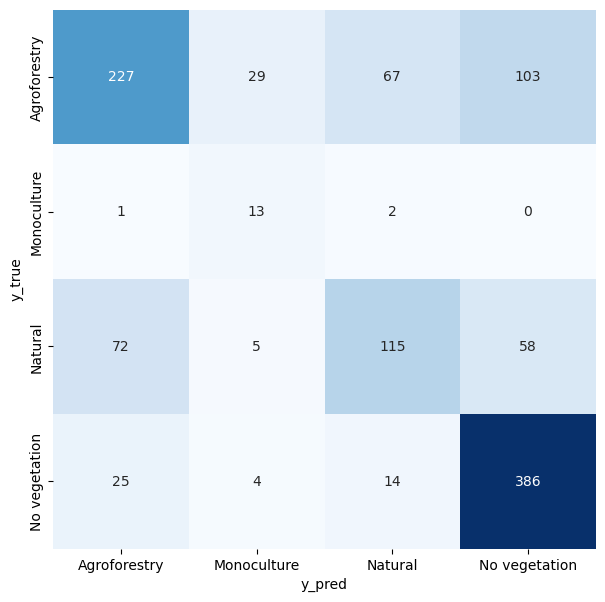

In [55]:
val_df = '../../data/validation/clean_validation_labels_013125.csv'
output_err_file = "../../data/validation/ci_error_adjustment.json"

err.pretty_print_metrics(val_df)

ci_summary = err.ci_error_adjustments(val_df,
                                      output_err_file)

df = pd.read_csv(val_df)
conf_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['y_true'], colnames=['y_pred'])
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

## Second Ex
Incorporates additional validation labels to account for those that were dropped during the labeling process and 3rd party review.

Classification accuracy 65.1%
Classification F1-score 64.0%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Monoculture          = 59.0 |  95.2  | 42.8
         * No vegetation        = 78.8 |  89.1  | 70.6
         * Agroforestry         = 58.1 |  49.7  | 69.8
         * Natural              = 50.7 |  44.9  | 58.1
Saving error metrics to ../../data/validation/ci_error_adjustment.json

Bootstrap Confidence Interval Summary (Mean ± Margin of Error):
Class Monoculture:
  Recall    = 94.69% ± 5.31%
  Precision = 43.06% ± 8.07%
Class No vegetation:
  Recall    = 88.96% ± 3.10%
  Precision = 70.27% ± 3.73%
Class Agroforestry:
  Recall    = 49.54% ± 4.46%
  Precision = 69.72% ± 4.82%
Class Natural:
  Recall    = 45.34% ± 6.21%
  Precision = 58.19% ± 7.01%

Overall Accuracy: 65.11% ± 2.69%


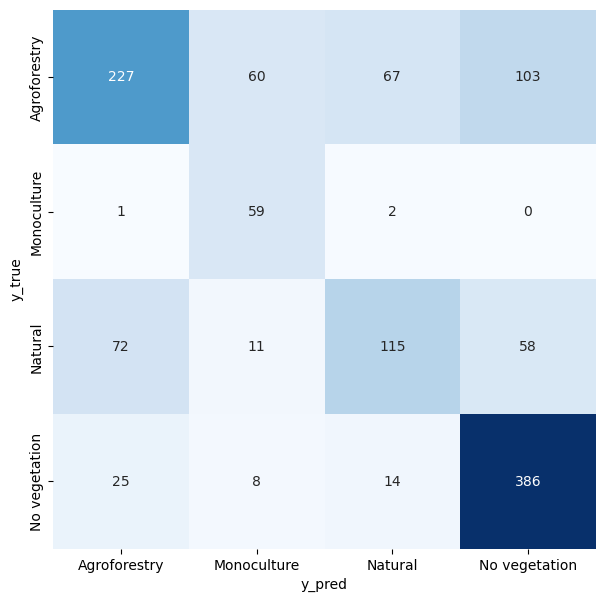

In [53]:
val_df = '../../data/validation/clean_validation_labels_032025.csv'
error_file = "../../data/validation/ci_error_adjustment.json"

err.pretty_print_metrics(val_df)

ci_summary = err.ci_error_adjustments(val_df,
                                      error_file)

df = pd.read_csv(val_df)
conf_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['y_true'], colnames=['y_pred'])
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

In [4]:
ci_summary

{'overall_accuracy': (0.6610169491525424, 0.02678412132024971),
 'No vegetation': {'recall': (0.898653177167404, 0.02958782308172403),
  'precision': (0.7067813707594495, 0.03655590072419679),
  'adj': 1.2714726425256297},
 'Agroforestry': {'recall': (0.530111716318482, 0.04640246962881911),
  'precision': (0.6976956366183898, 0.04949415443732863),
  'adj': 0.7598036858705922},
 'Monoculture': {'recall': (0.8, 0.2),
  'precision': (0.25268585589020204, 0.1194071673656119),
  'adj': 3.1659864664036395},
 'Natural': {'recall': (0.4601093022603624, 0.059335492736552836),
  'precision': (0.5798867989856216, 0.06721177017177121),
  'adj': 0.7934467607560953}}

# Internal Pub Revisions
To answer:
1. how does the stratified sample counts change with the new map version?
2. how can we extract the y_pred column using the new map (previously this was part of the CEO survey)?
3. how does the accuracy assessment change using the new map and additional validation samples?

### Check the stratified sample distribution

In [10]:
# rerunning the sample to determine if there is a major shift in proportions
# for the AF, natural and background class 
# This set of points will not be used - just identifying the difference in class propotions and sampled points

# OLD
# Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
# Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
# Sampling 563 points for class 0 out of 264952720 available pixels.
# Sampling 2 points for class 1 out of 1139546 available pixels.
# Sampling 318 points for class 2 out of 148586138 available pixels.
# Sampling 182 points for class 3 out of 85917262 available pixels.

# NEW
# Class distribution: {0: 268069617, 1: 2122966, 2: 174199043, 3: 63130612}
# Class proportions: {0: 52.82, 1: 0.42, 2: 34.32, 3: 12.44}

final = '../../tmp/ghana/preds/mosaic/final_2025-04-18.tif'
outfile = f'../../data/validation/stratified_sample/sampled_points_rev1.shp'
buffer = 1000
params_path = '../../params.yaml'

sampled_points = val.run_validation_workflow(final, 
                                             outfile,
                                             buffer,
                                             params_path,
                                             valv1=f'../../data/validation/ceo_survey/ceo-plantations-validation-jessica-plot-data-2024-10-29.csv',
                                             valv2=f'../../data/validation/ceo_survey/ceo-plantations-validation2-jessica-plot-data-2025-03-13.csv')

Class distribution: {0: 268069617, 1: 2122966, 2: 174199043, 3: 63130612}
Class proportions: {0: 52.82, 1: 0.42, 2: 34.32, 3: 12.44}
Total count (pixels): 507522238
Computing sample size...
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 1067.0
Sampling 563 points for class 0 out of 244648745 available pixels.
Sampling 4 points for class 1 out of 1468463 available pixels.
Sampling 366 points for class 2 out of 156919500 available pixels.
Sampling 132 points for class 3 out of 56691225 available pixels.


In [74]:
# these are all the valid consensus samples
# now just need to update the y_pred column with the new geotif
stacked_df.head()

,lon,lat,y_true,y_pred
0,-2.071047,10.615168,Agroforestry,No vegetation
1,-0.100567,6.578401,No vegetation,No vegetation
2,-0.827740,10.418476,Agroforestry,No vegetation
3,-0.488447,10.894204,No vegetation,No vegetation
4,-0.735697,10.335053,No vegetation,No vegetation


### create new y_pred column

In [86]:
with rs.open(final) as src:
    # Ensure lat/lon match raster CRS
    if src.crs.to_string() != "EPSG:4326":
        raise ValueError(f"Raster CRS is {src.crs}, but expected EPSG:4326.")

    # Extract raster values at each point
    coords = list(zip(stacked_df['lon'], stacked_df['lat']))
    stacked_df['y_pred_new'] = [val[0] for val in src.sample(coords)]

pl_pred_map = {
    0: 'No vegetation',
    1: 'Monoculture',
    2: 'Agroforestry',
    3: 'Natural'}
stacked_df['y_pred_new'] = stacked_df['y_pred_new'].map(pl_pred_map)
clean_val_labels  = stacked_df.drop(columns='y_pred').rename(columns={'y_pred_new': 'y_pred'})
clean_val_labels.to_csv('../../data/validation/clean_validation_labels_042125.csv')

In [87]:
clean_val_labels

,lon,lat,y_true,y_pred
0,-2.071047,10.615168,Agroforestry,No vegetation
1,-0.100567,6.578401,No vegetation,No vegetation
2,-0.827740,10.418476,Agroforestry,No vegetation
3,-0.488447,10.894204,No vegetation,No vegetation
4,-0.735697,10.335053,No vegetation,No vegetation
...,...,...,...,...
1203,-1.271634,5.927286,Agroforestry,Monoculture
1204,-1.475246,6.057815,Natural,Monoculture
1205,-1.502015,6.056826,Natural,Monoculture
1206,-1.579115,5.620382,Monoculture,Monoculture


### rerun the accuracy assessment
Note that this switches the axes for y_true and y_pred

Classification accuracy 65.2%
Classification F1-score 63.5%

             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * Agroforestry         = 61.0 |  57.5  | 64.8
         * Monoculture          = 62.7 |  85.5  | 49.5
         * Natural              = 42.8 |  33.6  | 58.9
         * No vegetation        = 78.6 |  89.1  | 70.3
Saving error metrics to ../../data/validation/ci_error_adjustment_042125.json

Bootstrap Confidence Interval Summary (Mean ± Margin of Error):
Class Agroforestry:
  Recall    = 57.52% ± 4.53%
  Precision = 64.75% ± 4.75%
Class Monoculture:
  Recall    = 85.01% ± 8.54%
  Precision = 49.73% ± 9.73%
Class Natural:
  Recall    = 33.59% ± 5.96%
  Precision = 58.70% ± 7.97%
Class No vegetation:
  Recall    = 89.02% ± 2.86%
  Precision = 70.24% ± 3.76%

Overall Accuracy: 65.27% ± 2.69%


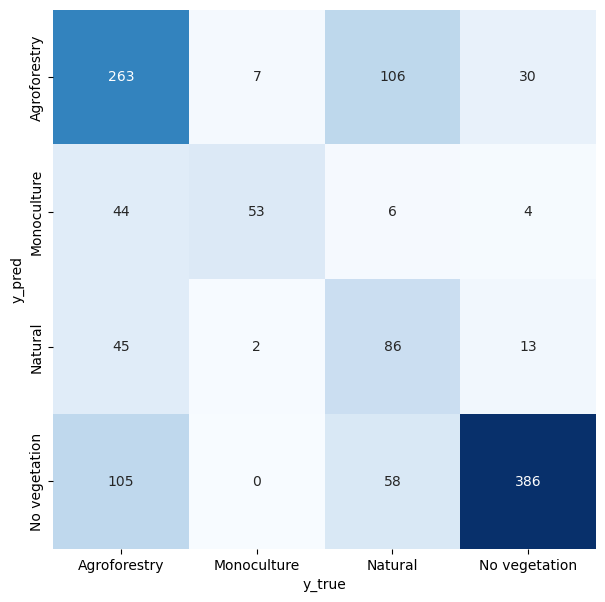

In [91]:
val_df = '../../data/validation/clean_validation_labels_042125.csv'
output_err_file = "../../data/validation/ci_error_adjustment_042125.json"

err.pretty_print_metrics(val_df)

ci_summary = err.ci_error_adjustments(val_df,
                                      output_err_file)

df = pd.read_csv(val_df)
conf_matrix = pd.crosstab(df['y_pred'], df['y_true'], rownames=['y_pred'], colnames=['y_true'])
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

### Investigate

In [45]:
# things to check
# were there any situations where john, jess and dan disagree
df1 = confirm_ready(jess1)
df2 = confirm_ready(john1)
df3 = daniel1.rename(columns={"System": "system"})
df3 = df3[['plotid', 'system']] 
consensus = df1.merge(df2[['plotid', 'system', 'pl_pred']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
consensus = consensus.merge(df3, 
                            on='plotid', 
                            how='left', 
                            suffixes=('', '_dan'))
consensus.rename(columns={'system': 'system_dan',
                         'pl_pred_jess':'pl_pred'}, inplace=True)
df = consensus[['plotid', 'pl_pred', 'system_jess','system_john', 'system_dan']]

In [46]:
df1 = confirm_ready(jess2)
df2 = confirm_ready(john2)
df3 = daniel2.rename(columns={"System": "system"})
df3 = df3[['plotid', 'system']] 
consensus = df1.merge(df2[['plotid', 'system', 'pl_pred']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
consensus = consensus.merge(df3, 
                            on='plotid', 
                            how='left', 
                            suffixes=('', '_dan'))
consensus.rename(columns={'system': 'system_dan',
                         'pl_pred_jess':'pl_pred'}, inplace=True)
df2 = consensus[['plotid', 'pl_pred', 'system_jess','system_john', 'system_dan']]

In [47]:
a = df[~df.system_dan.isna()]
a = a[
    (df['system_jess'] != df['system_john']) &
    (df['system_jess'] != df['system_dan']) &
    (df['system_john'] != df['system_dan'])
]

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_7038/546030841.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = a[


In [48]:
a

,plotid,pl_pred,system_jess,system_john,system_dan
34,34,0,No vegetation,Natural,Agroforestry
39,39,0,No vegetation,Natural,Agroforestry
54,54,0,Agroforestry,No vegetation,Natural
55,55,0,No vegetation,Natural,Agroforestry
58,58,0,No vegetation,Agroforestry,Natural
69,69,0,No vegetation,Natural,Agroforestry
94,94,0,Natural,No vegetation,Agroforestry
117,117,0,No vegetation,Natural,Agroforestry
119,119,0,No vegetation,Natural,Agroforestry
146,146,0,No vegetation,Natural,Agroforestry


In [49]:
len(a)

22

In [50]:
# what were the labels for all the monoculture classes
df[df.pl_pred == 1]

,plotid,pl_pred,system_jess,system_john,system_dan
563,563,1,Agroforestry,Agroforestry,NaN
564,564,1,Monoculture,Monoculture,NaN


# Other Exercises

In [5]:
# create a comb mosaic
def mosaic_tif(tifs_to_mosaic, outpath):

    ''''
    Takes in a list of raster files and
    merges them to form a single tif.

    '''
    dir = f'../../tmp/ghana/preds/mosaic/'
    reader_mode = []

    for file in tifs_to_mosaic:
        src = rs.open(dir+file)
        reader_mode.append(src) 
    print(f'Merging {len(reader_mode)} tifs.')

    mosaic, out_transform = merge(reader_mode)
    date = datetime.today().strftime('%Y-%m-%d')
    outpath = f"{dir}{outpath}_{date}.tif"
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint8',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw',
                     'nodata': 255})

    with rs.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Ensure to close all files
    for src in reader_mode:
        src.close()

    return None

In [7]:
tifs = ['pd_north_v30_2025-04-17.tif',
        'pd_east_v30_2025-04-17.tif',
        'pd_west_v30_2025-04-17.tif',
       ]

mosaic_tif(tifs, 'final')

Merging 3 tifs.
